<font size=7> HC112823 acid Buzsaki Latencies 

Good electrode pairs: 
[170,  86] 
[118, 205]


plot_pair_analysis( 170, 86, sd)

# Import stuff, get data

I attempt to get Sury's code for analyzing connectivity working.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import signal

import math
from scipy.sparse import csr_array
import random

import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, read_phy_files,\
                                  plot_latency_dist_hist, plot_latency_angle_hist, read_autocurated_data, plot_pair_analysis
from human_hip.animate import animate_latencies

In [2]:
sd = read_autocurated_data( "/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112823_avv9hckcr1_21841_120323_3_acqm.zip" )


# with open("/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl", "rb") as filename:
#     sd = pickle.load(filename)


# <font color="grey"> Helper Code


Code is adapted from `latencies.py` in the `src` folder

## <font color="grey"> latencies

In [3]:

import numpy as np
from scipy.signal import correlate, correlation_lags



def latencies(neuron1, neuron2, sd, ms_cutoff_low=0, ms_cutoff_high=20 ):
    """
    Function:
        returns all the latencies that occur between two neurons, n1 and n2. 
        A latency is defined as the time difference between a spike from n1 and the nearest spike from n2 (positive or negative)
    Inputs:
        neuron1 (integer): index of the neuron, n1 
        neuron2 (integer): index of the neuron, n2, *note* if n1 occurs before n2, the latency will be positive
        sd (SpikeData object): contains the original spike data from the recording
        ms_cutoff (integer): the maximum latency to be considered, in milliseconds
    Outputs:
        cur_latencies (np.array): the time difference between n1 and n2, for ever latency occurence less than ms_cutoff
    """
    train1 = sd.train[ neuron1 ]
    train2 = sd.train[ neuron2 ]    
    cur_latencies = []
    for time in train1:
        abs_diff_ind = np.argmin(np.abs(train2 - time))  # Subtract time from all spikes in the train and take the absolute value        
        latency = np.array(train2)-time       # Calculate the actual latency
        latency = latency[abs_diff_ind]

        if np.abs(latency) <= ms_cutoff_high and np.abs(latency) >= ms_cutoff_low : # Only append latencies within a certain time cutoff
            cur_latencies.append(latency)
    return np.array(cur_latencies)



## <font color="grey"> Cross Sttc

<font color="orange">I change the original code to calculate the cross sttc from -50-50ms instead of -1000-1000ms. This is done to speed up the calculation.

In [4]:

def cross_sttc( n1, n2, sd, delt=20 ):
    """
    Function: Calculates the cross correlation from -1000ms to 1000ms, expcept using the spike time tiling coefficient, between two neurons, n1 and n2
    Inputs:
        n1 (integer): index of the neuron, n1 
        n2 (integer): index of the neuron, n2
        sd (SpikeData object): contains the original spike data from the recording
        delt (integer): the time window to calculate the spike time tiling coefficient over
    Outputs:
        sttc (float): the spike time tiling coefficient for each shift between n1 and n2
    """
    assert len(sd.neuron_data[0]) == len(sd.train) 
    sttcs = []
    for i in range(-30,31):
        sd.train.append( sd.train[n1]+i )
        sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )
        sd.train.pop(-1)
    return np.array(sttcs)


## <font color="grey">Poission Probability <small> Sury Code

Probability of computing n or more event given lambda_

<font color="orange"> I have to still check that Sury's code is correct

In [5]:
def p_fast(n, lambda_):
    """
    A poisson estimation of the probability of observing n or more events
    """
    ## take log to make sure the factorial does not overflow
    # add poisson_var when x = 0, 1, take log after calculation to avoid log(0)
    if n > 1:
        poisson_01 = [np.exp(-lambda_)*lambda_**x/math.factorial(x) for x in [0, 1]]
        poisson_res = [np.exp(-lambda_ + x*math.log(lambda_) - math.log(math.factorial(x))) for x in range(2, n)]
        poisson_var = poisson_01 + poisson_res
    else:
        poisson_var = [np.exp(-lambda_)*lambda_**x/math.factorial(x) for x in range(n)]
    continuity_correction = np.exp((math.log(0.5) - lambda_ + n*math.log(lambda_)) - math.log(math.factorial(n)))
    return 1 - np.sum(poisson_var) - continuity_correction


## <font color="grey"> Plot Pair Latencies

In [6]:

import warnings
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint
import diptest 
from ipywidgets import interact_manual, interact

def plot_pair_analysis( n1, n2, sd):
    
    lag = np.median(latencies( n1, n2, sd))
    if lag<0:
        start_i = n2
        end_i = n1
    else:
        start_i = n1
        end_i = n2

    # Layout Plot
    warnings.filterwarnings("ignore")
    plot_footprint( sd, [start_i, end_i] )
    
    # Summary Stats
    latencies_raw = latencies( start_i, end_i, sd, ms_cutoff_high=10  )
    latencies_clean = latencies_raw
    #latencies_clean = latencies_raw[ np.where( np.abs(latencies_raw) < 15 )[0] ]
    

    
    
    print( "Number of Latencies", len(latencies_clean) )
    print( "Mean Latency", round(np.mean(latencies_clean), 3) )
    print( "Median Latency", round(np.median(latencies_clean), 3) )
    #print( "Latency Probability", {round(100*(len(lates_filtered)/len(lates_raw)))})
    print("STTC", sd.spike_time_tiling( start_i, end_i) )
    print("Diptest P-val", round( diptest.diptest(latencies_clean)[1] , 3) )
    print( "Latency Probability", round(len(latencies_clean)/len(latencies_raw), 3) )
    print(".")
    print( "Sender Neuron", start_i)
    print( "Sender   Firing Rate", round(sd.rates(unit='Hz')[start_i] , 3) )
    print(".")
    print("Receiver Neuron", end_i)
    print( "Receiver Firing Rate", round(sd.rates(unit='Hz')[end_i], 3) )
    
    # Plot other graphs
    figs, plots = plt.subplots(nrows=3,ncols=2,figsize=(14,10))

    mean_latency = np.mean(latencies_clean)     # Get mean and SD
    std_latency = np.std(latencies_clean)
    cutoff = 2 * std_latency           # remove outliers
    lates_filtered = [latency for latency in latencies_clean if abs(latency - mean_latency) <= cutoff]
    plots[0,0].hist(lates_filtered, bins=12, alpha=0.7, label='Latency')
    plots[0,0].axvline(mean_latency, color='red', linestyle='dashed', linewidth=2, label='Mean')
    plots[0,0].axvline(mean_latency - std_latency, color='green', linestyle='dashed', linewidth=2, label='Std -')
    plots[0,0].axvline(mean_latency + std_latency, color='green', linestyle='dashed', linewidth=2, label='Std +')
    plots[0,0].axvline(0, color='black', linestyle='dashed', linewidth=0.5, label='Std +')
    plots[0,0].set_xlim(-1*(abs(mean_latency)+cutoff), abs(mean_latency) + cutoff) 
    plots[0,0].set_xlabel("Latency (ms)")
    plots[0,0].set_ylabel("Count")
    plots[0,0].set_title(f"Fancy Latency Histogram")
    plots[0,0].legend()

    plots[0,1].hist(latencies_clean, bins=12)
    plots[0,1].set_title("Latency Histogram")
    plots[0,1].set_xlabel("Latency (ms)")
    plots[0,1].set_ylabel("Count")

    isi = sd.interspike_intervals()[start_i]
    plots[1,0].hist( isi[ isi<200 ], bins=50);
    plots[1,0].set_title("Sender ISI")
    plots[1,0].set_xlabel("Time bin(ms)")
    plots[1,0].set_ylabel("ISI count")

    isi = sd.interspike_intervals()[end_i]
    plots[1,1].hist( isi[ isi<200 ] , bins=50);
    plots[1,1].set_title("Receiver ISI")
    plots[1,1].set_xlabel("Time bin(ms)")
    plots[1,1].set_ylabel("ISI count")
    
    
    plots[2,0].plot( sd.neuron_data[0][start_i]["template"] )
    plots[2,0].set_title("Sender Spike Waveform")
    plots[2,0].set_xlabel("")
    plots[2,0].set_ylabel("")
    
    plots[2,1].plot( sd.neuron_data[0][end_i]["template"] )
    plots[2,1].set_title("Receiver Spike Waveform")
    plots[2,1].set_xlabel("")
    plots[2,1].set_ylabel("")




In [7]:
# isi_og = sd.interspike_intervals()[5]
# isi = isi_og[ isi_og<200 ]

## <font color="grey"> Histogram

In [8]:
def pairs_hisogram(pairs, sd, ms_cutoff_high=15):
    @interact
    def plot_pair(pair = (0, len(pairs)-1) ):
        latencies_pair = latencies( pairs[pair,0], pairs[pair,1], sd, ms_cutoff_high=20  )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)

# <font color="magenta"> Busaki 2 & 1.5ms Latency Cutoff

In [9]:
sttc_cutoff = 0.04
sttc_delta=20 

# Get all latencies whose STTC is above some minimum STTC cuttoff
print(sd.N**2 , "Starting Pairs")
sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
for i in range(sd.N):
    for j in range(i+1,sd.N):
        if sttc_neo[i,j] > sttc_cutoff:
            pairs.append([i,j])
print( len(pairs), "pairs above sttc cutoff")


44944 Starting Pairs
11079 pairs above sttc cutoff


In [10]:

# Get all latencies whose median latency is above some minimum Latency Cuttoff
pairs_late = [] #lags_late = []
for pair in pairs:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=15)  #latency= np.median(pair_latencies)
    if abs(np.mean(pair_latencies))> 1.5 and len(pair_latencies)>20: #abs(np.median(pair_latencies))> 1.5 and 
        if np.mean(pair_latencies) < 0:
            pairs_late.append( [pair[1], pair[0]] )  #lags_late.append( latency )
        else:
            pairs_late.append( pair )
print( len(pairs_late), "pairs above latencency cutoff")


928 pairs above latencency cutoff


In [11]:
# Buzsaki Method
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8

pairs_pois = []
pvals = []
for pair in pairs_late:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.0005:
        pairs_pois.append( pair )
        pvals.append(p_val)
pairs_pois = np.array(pairs_pois)
print( len(pairs_pois), "pairs above poisson cutoff")

/tmp/ipykernel_1093/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_1093/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


583 pairs above poisson cutoff


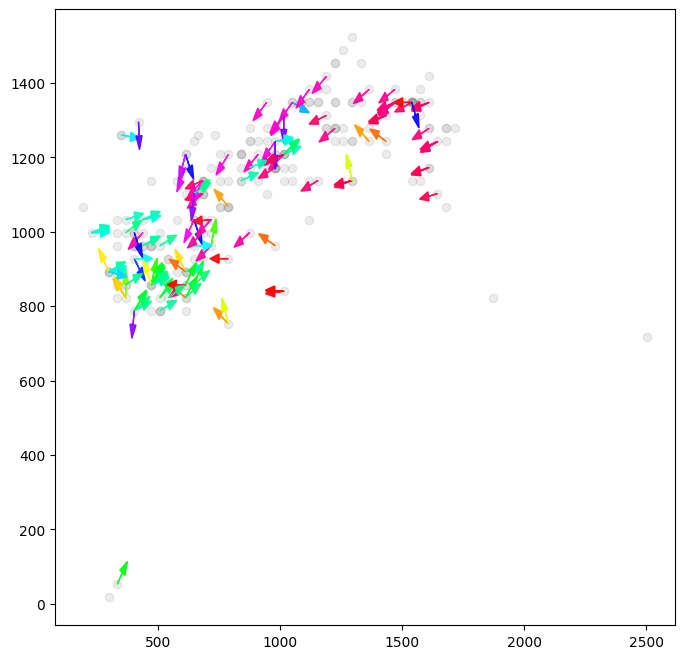

In [12]:
plot_vector_layout( sd, pairs_pois[0:150])

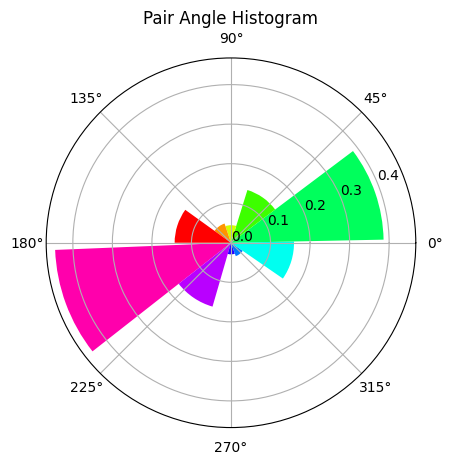

In [13]:
plot_latency_angle_hist(sd, pairs_pois , by_firing_rate=True)

In [15]:
pairs_hisogram(pairs_pois, sd, ms_cutoff_high=15)

interactive(children=(IntSlider(value=291, description='pair', max=582), Output()), _dom_classes=('widget-inte…

In [41]:
pvals=np.array(pvals)
pairs_pois2 = pairs_pois[pvals < 1e-12]
len(pairs_pois2)

102

In [37]:
#pairs_pois[782]
pairs_pois[372]


array([170,  86])

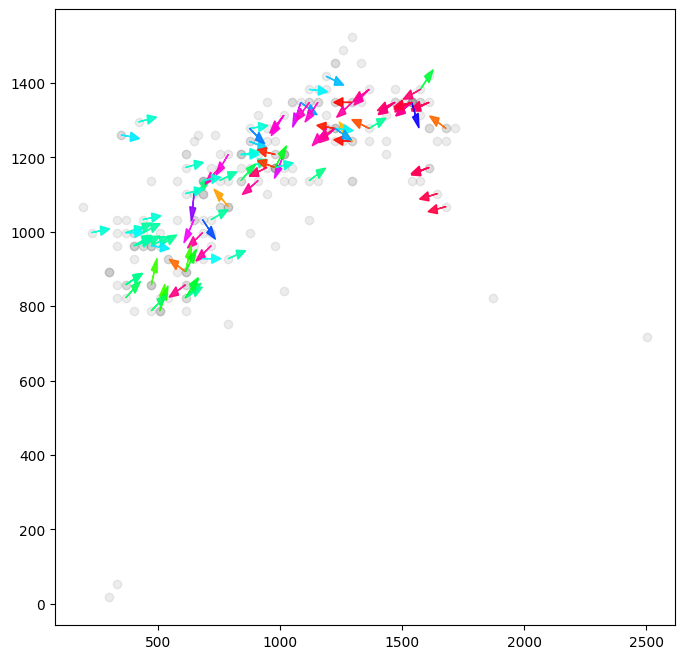

In [42]:
plot_vector_layout( sd, pairs_pois2)

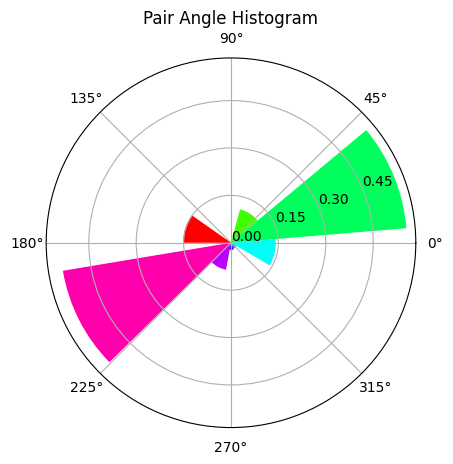

In [43]:
plot_latency_angle_hist(sd, pairs_pois2 , by_firing_rate=True)

In [44]:
pairs_hisogram(pairs_pois2, sd, ms_cutoff_high=15)

interactive(children=(IntSlider(value=50, description='pair', max=101), Output()), _dom_classes=('widget-inter…

In [45]:
pairs_pois2[77]

array([118, 205])

# <font color="orange"> Curation low latency 10ms

In [46]:
sttc_cutoff = 0.04
latency_cutoff=1
sttc_delta=20 

# Get all latencies whose STTC is above some minimum STTC cuttoff
print(sd.N**2 , "Starting Pairs")
sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
for i in range(sd.N):
    for j in range(i+1,sd.N):
        if sttc_neo[i,j] > sttc_cutoff:
            pairs.append([i,j])
print( len(pairs), "pairs above sttc cutoff")


44944 Starting Pairs
11079 pairs above sttc cutoff


In [36]:

# Get all latencies whose median latency is above some minimum Latency Cuttoff
pairs_late = [] #lags_late = []
for pair in pairs:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=10)  #latency= np.median(pair_latencies)
    if abs(np.median(pair_latencies))> latency_cutoff and abs(np.mean(pair_latencies))> latency_cutoff and len(pair_latencies)>30:
        if np.median(pair_latencies) < 0:
            pairs_late.append( [pair[1], pair[0]] )  #lags_late.append( latency )
        else:
            pairs_late.append( pair )
pairs10= pairs_late
print( len(pairs_late), "pairs above latencency cutoff")



436 pairs above latencency cutoff


In [37]:
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8
sttc_delta=20 

In [38]:
pairs_pois = []
pvals = []
for pair in pairs10:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.0005:
        pairs_pois.append( pair )
        pvals.append(p_val)
pairs_pois = np.array(pairs_pois)

In [39]:
pvals = np.array(pvals)

In [41]:
pairs_pois2 = pairs_pois[pvals < 1e-11]

In [42]:
len(pairs_pois2)

32

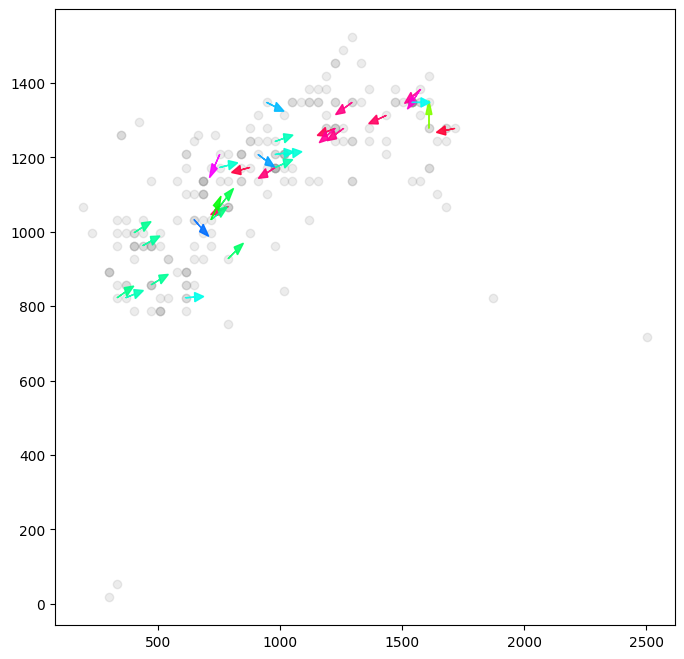

In [43]:
plot_vector_layout( sd, pairs_pois2)

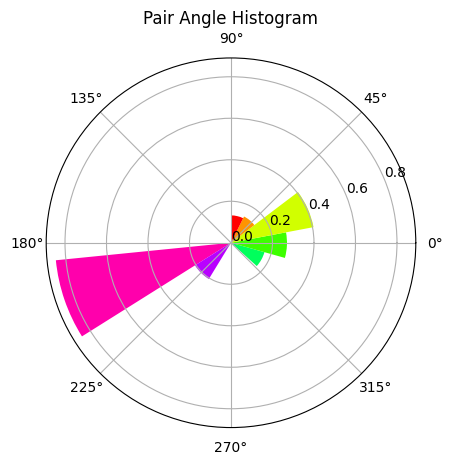

In [44]:
plot_latency_angle_hist(sd, pairs_pois2 , by_firing_rate=True)

In [62]:
@interact
def plot_pair(pair = (0, len(pairs_pois2)-1 )):
    plot_pair_analysis( pairs_pois2[pair,0], pairs_pois2[pair,1], sd )

interactive(children=(IntSlider(value=15, description='pair', max=31), Output()), _dom_classes=('widget-intera…

In [53]:
@interact_manual
def checkit( a = (0,4) ):
    print(a)

interactive(children=(IntSlider(value=2, description='a', max=4), Button(description='Run Interact', style=But…

In [9]:
len(pairs)

4456

In [7]:
#pickle.dump(pairs, open("sanity_20minlates.pkl", "wb"))


In [29]:
pair

[0, 52]

In [30]:
# for pair in pairs:
pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=20)  #latency= np.median(pair_latencies)
#     if abs(np.median(pair_latencies))> latency_cutoff and len(pair_latencies)>20:
#         if np.median(pair_latencies) < 0:
#             pairs_late.append( [pair[1], pair[0]] )  #lags_late.append( latency )
#         else:
#             pairs_late.append( pair )
# pairs= pairs_late
# print( len(pairs_late), "pairs above latencency cutoff")



In [33]:
pair_latencies
np.median(pair_latencies)


# Single Pair Analysis

In [42]:
pair = pairs[5]
pair

[0, 52]

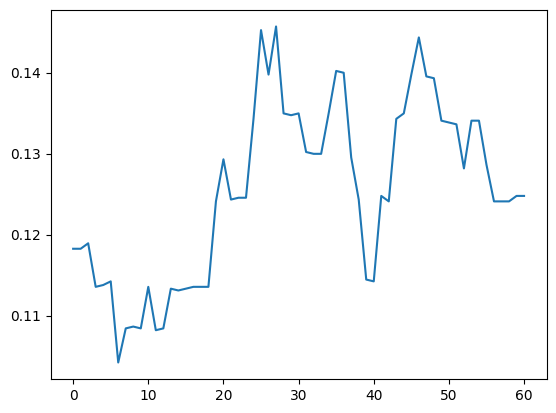

In [46]:
sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
plt.plot(sttcs)

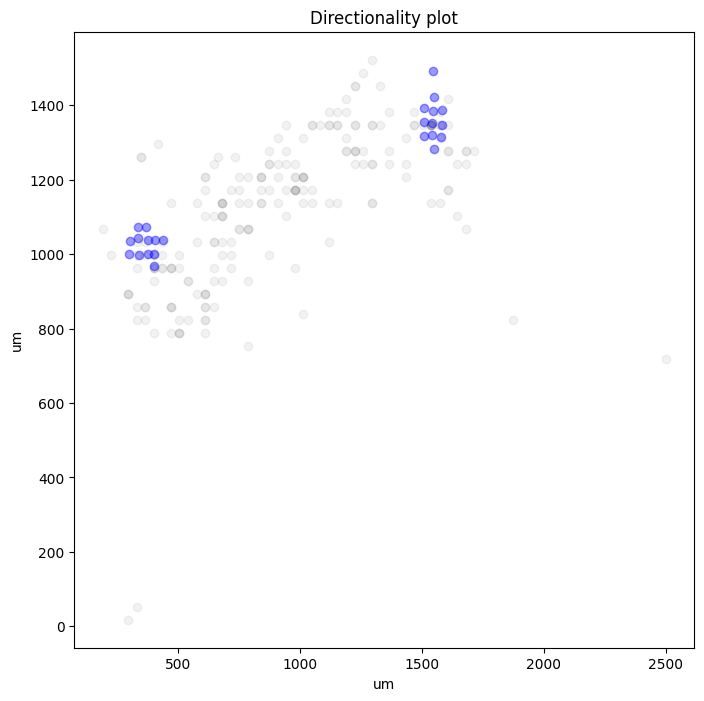

Number of Latencies 231
Mean Latency 0.897
Median Latency 1.0
STTC 0.11458785414047426
Diptest P-val 0.614
Latency Probability 1.0
.
Sender Neuron 0
Sender   Firing Rate 6.176
.
Receiver Neuron 45
Receiver Firing Rate 1.736


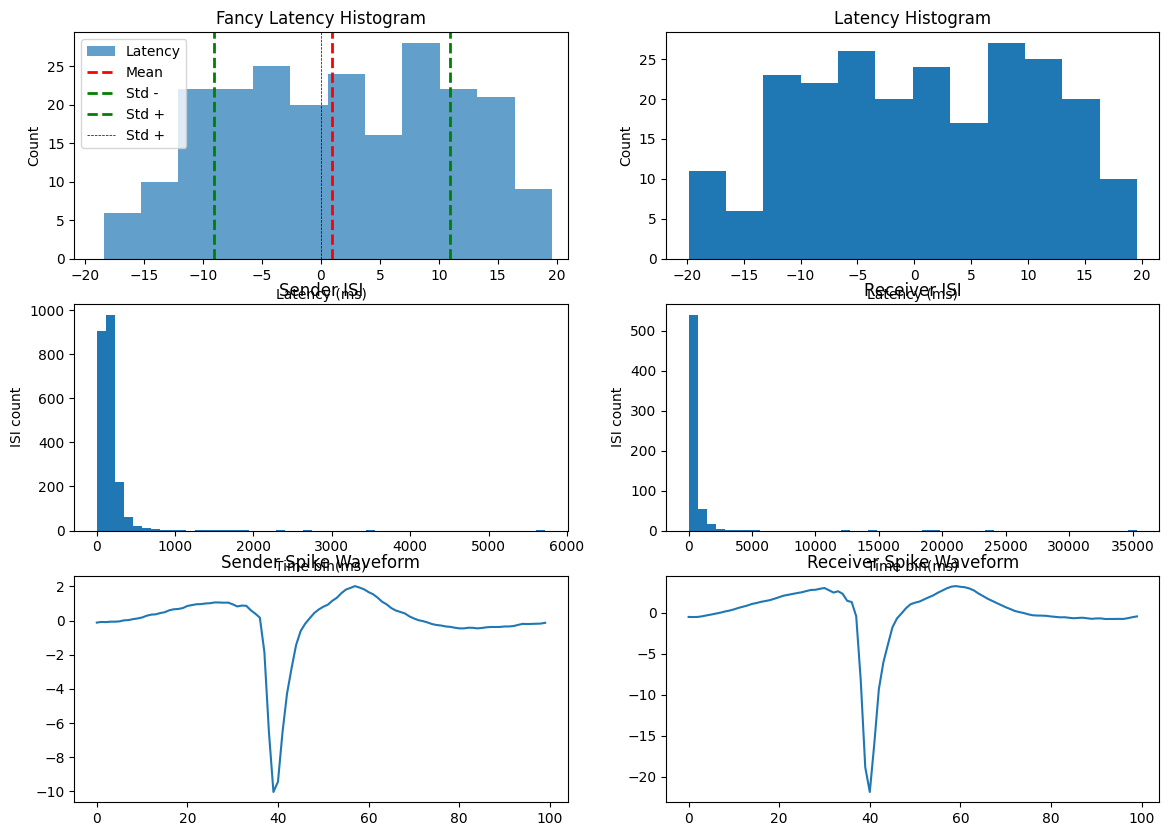

In [47]:
plot_pair_analysis( 0,45, sd )

In [24]:
plot_pair_analysis

<function human_hip.spike_data.plot_latencies.plot_pair_analysis(n1, n2, sd)>

# Buzsaki Method STTC

<font color="orange"> Original paper only considered lags between 0.8-2.8ms. We consider broader range

In [48]:
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8
sttc_delta=20 

In [57]:
pairs_pois = []
pvals = []
for pair in pairs:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.0005:
        pairs_pois.append( pair )
        pvals.append(p_val)
pairs_pois = np.array(pairs_pois)

## <font color="green"> Buszaki 2

get smallest p-values

In [84]:
# plt.hist(pvals, bins=100)
# plt.xlim(0,.0001)

In [85]:
pvals = np.array(pvals)

In [92]:
np.array(pvals) < 1e-11

array([ True, False, False, ..., False, False,  True])

In [132]:
pairs_pois2 = pairs_pois[pvals < 1e-12]

In [133]:
len(pairs_pois2)

487

In [23]:
@interact_manual
def plot_pair(pair = range(len(pairs_pois2)) ):
    plot_pair_analysis( pairs_pois2[pair,0], pairs_pois2[pair,1], sd )


interactive(children=(Dropdown(description='pair', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [129]:
len(pairs_pois)
len(pvals)

3064

In [108]:
pairs_pois2

array([[  0,  18],
       [  0,  78],
       [210,   0],
       [ 19,   2],
       [ 46,   2],
       [ 63,   2],
       [135,   2],
       [155,   2],
       [  2, 189],
       [136,   3],
       [  3, 166],
       [  3, 170],
       [  4,  96],
       [122,   4],
       [183,   4],
       [191,   4],
       [  5,  88],
       [  6,  30],
       [ 50,   6],
       [  6, 105],
       [109,   6],
       [  6, 115],
       [  6, 163],
       [178,   6],
       [  6, 204],
       [  7,   8],
       [ 26,   7],
       [ 45,   7],
       [104,   7],
       [151,   7],
       [152,   7],
       [160,   7],
       [182,   7],
       [ 59,   8],
       [  8, 159],
       [  9,  47],
       [  9, 186],
       [ 10, 158],
       [ 11, 115],
       [ 39,  13],
       [ 70,  13],
       [157,  13],
       [186,  13],
       [ 14, 101],
       [133,  14],
       [150,  14],
       [170,  14],
       [ 14, 173],
       [185,  14],
       [190,  14],
       [ 26,  15],
       [ 28,  15],
       [ 38,

In [105]:
to_keep = random.sample(range(len(pairs_pois2)), 200)

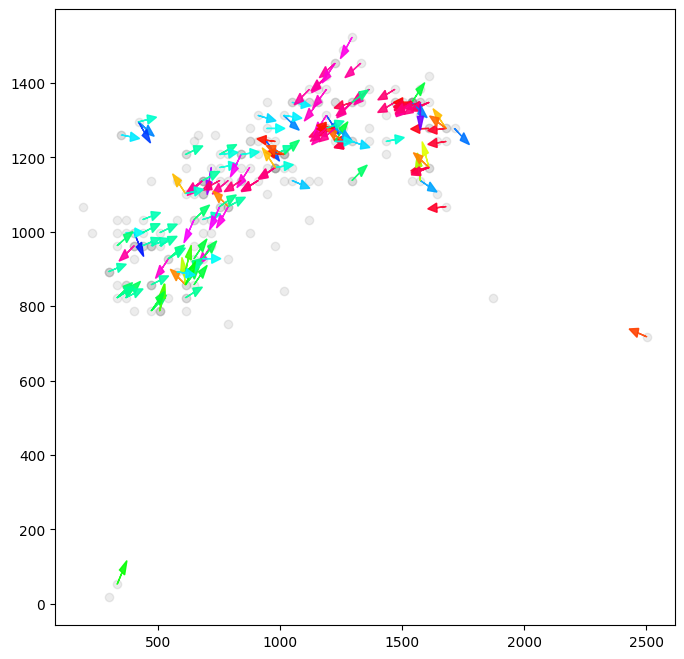

In [130]:
plot_vector_layout( sd, pairs_pois2)

In [ ]:
range(len(pairs_pois2))

In [136]:
@interact_manual
def plot_pair(pair = range(len(pairs_pois2)) ):
    plot_pair_analysis( pairs_pois2[pair,0], pairs_pois2[pair,1], sd )


interactive(children=(Dropdown(description='pair', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

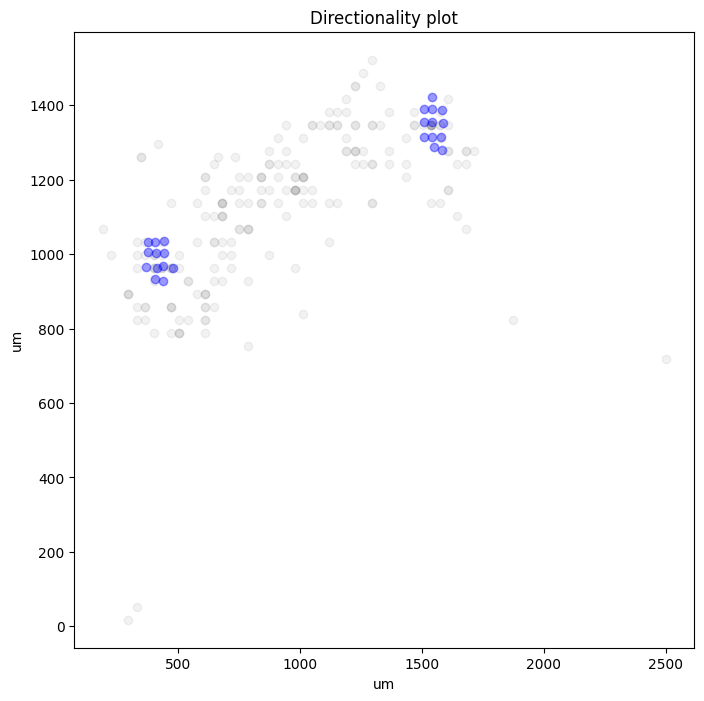

Number of Latencies 240
Mean Latency 0.599
Median Latency 1.25
STTC 0.0440837980757793
Diptest P-val 0.839
Latency Probability 1.0
.
Sender Neuron 46
Sender   Firing Rate 2.627
.
Receiver Neuron 2
Receiver Firing Rate 5.56


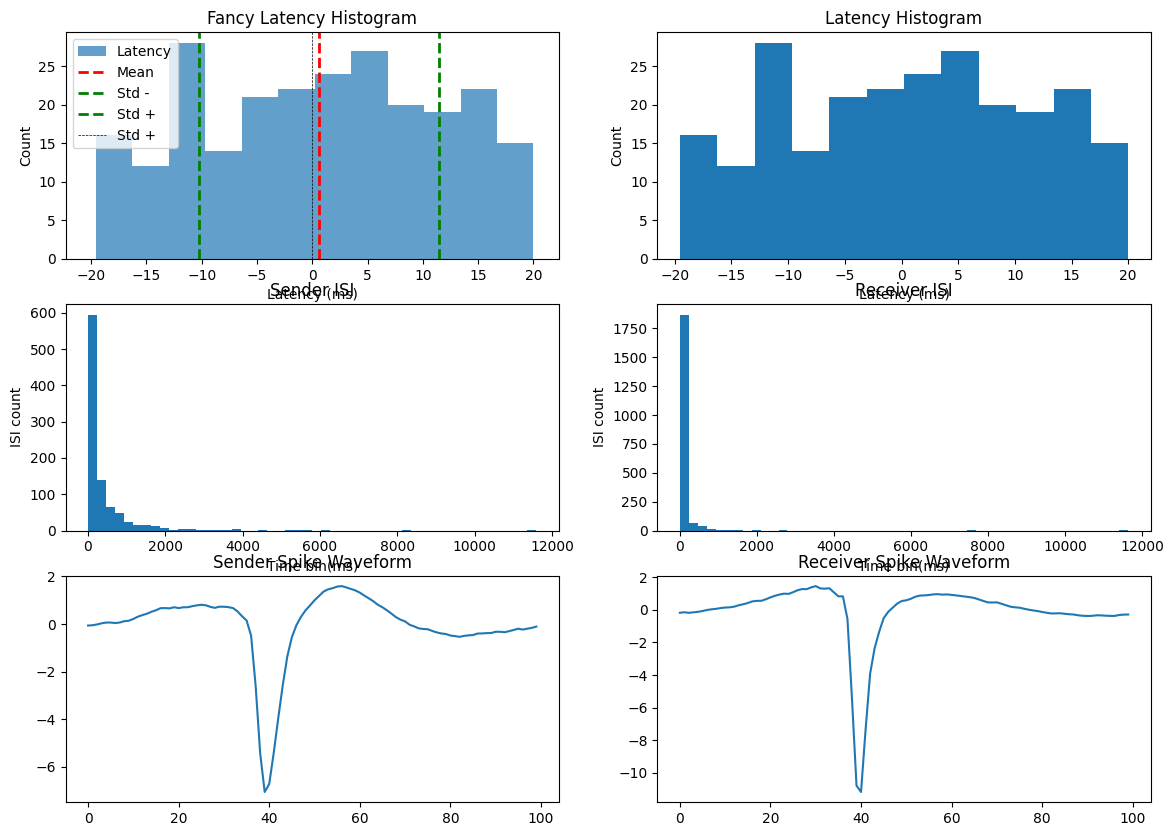

In [116]:
plot_pair_analysis( 46, 2, sd )

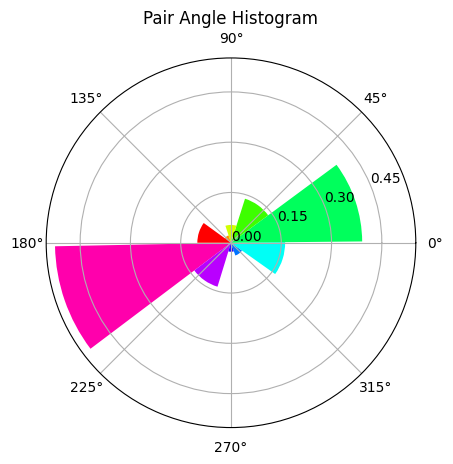

In [134]:
plot_latency_angle_hist(sd, pairs_pois2 , by_firing_rate=True)

# Buzsaki 1

In [99]:
to_keep = random.sample(range(len(pairs_pois2)), 200)

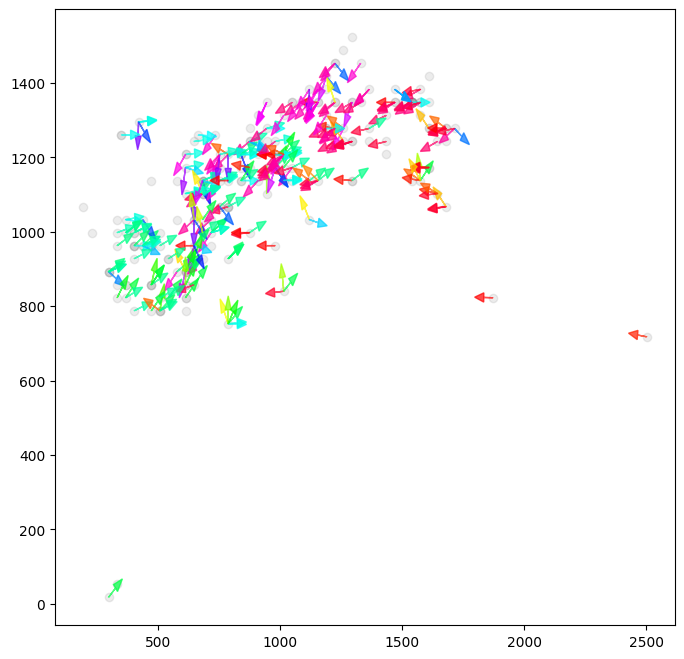

In [14]:
plot_vector_layout( sd, pairs_pois[to_keep] )

In [ ]:
plot_vector_layout( sd, pairs_pois[to_keep] )

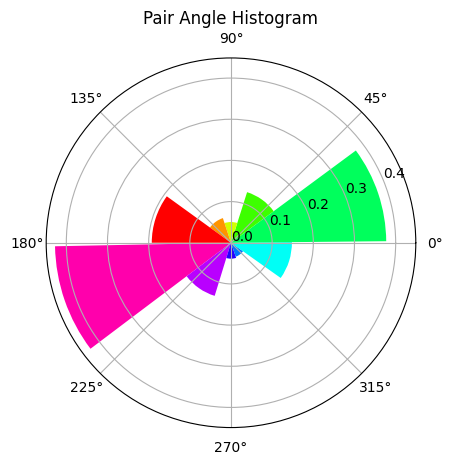

In [34]:
plot_latency_angle_hist(sd, pairs_pois , by_firing_rate=True)